# Install and import necessary libraries

In [ ]:
pip install 'portalocker>=2.0.0'

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
pip install --upgrade torchtext

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 19.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 619.9/619.9 MB 1.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 75.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.0/21.0 MB 57.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.1/317.1 MB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 168.4/168.4 MB 6.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 173.2/173.2 MB 7.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 557.1/557.1 MB 2.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 849.3/849.3 kB 42.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 MB 13.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 177.1/177.1 MB 5.9 MB/s eta 0:00:00
     ━━━━━━━━━

In [ ]:
import torch
import torch.nn as nn
import torchtext
from torchtext.datasets import IMDB
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import vocab
from torch.utils.data import Dataset, DataLoader, TensorDataset
import numpy as np
import collections
import torch.optim as optim
import torch.nn.functional as F
import matplotlib.pyplot as plt
import urllib.request
import os
import tarfile

# Load the IMDB dataset

In [ ]:
url = "http://ai.stanford.edu/~amaas/data/sentiment/aclImdb_v1.tar.gz"
filename = "aclImdb_v1.tar.gz"
if not os.path.isfile(filename):
    urllib.request.urlretrieve(url, filename)

if not os.path.isdir("aclImdb"):
    with tarfile.open(filename, "r:gz") as tar:
        tar.extractall()


In [ ]:
dataset_dir = "aclImdb"

labels = {
    "pos": 1,
    "neg": 0
}

train_dataset = []
test_dataset = []

for label, sentiment in labels.items():
    dir_path = os.path.join(dataset_dir, "train", label)
    file_list = os.listdir(dir_path)
    
    for filename in file_list:
        file_path = os.path.join(dir_path, filename)
        
        with open(file_path, "r") as f:
            text = f.read()

        train_dataset.append((sentiment, text))


for label, sentiment in labels.items():
    dir_path = os.path.join(dataset_dir, "test", label)
    file_list = os.listdir(dir_path)
    
    i = 0
    for filename in file_list:
        file_path = os.path.join(dir_path, filename)
        
        with open(file_path, "r") as f:
            text = f.read()

        test_dataset.append((sentiment, text))
        i = i + 1
        if i == 2500:
          break

In [ ]:
print(len(train_dataset))
for label, text in test_dataset:
  if label == 0:
    print(text)
    break
for label, text in test_dataset:
  if label == 1:
    print(text)
    break

25000
European films may be slower-paced and less plot driven than American films, but this takes it way too far. It also show a whole bunch of incompletely drawn characters doing inexplicable things. It's not fantasy, it's not even surreal, it's just awkward and bad.<br /><br />What's the message here? That people in France are pensive and gaze morosely a lot? That they like to watch other people having sex? They they spontaneously scream or touch a stranger on his neck? Do not wear a watch when seeing this film, as you will be astonished at how little is explained or learned over huge stretches of time.<br /><br />This is the story of a "police superintendent" who is deeply troubled by the brutal murder of a little girl, though actually he seems troubled before then. He is not merely upset at his own personal tragedies, but apparently mentally quite slow, behaving very much like a learning-disabled six-year old child. He stares blankly a lot, walks with arms rigid like a little kid, 

# Preprocess data

In [ ]:
''' Alternative way to define max_len
lengths = [len(tokenizer(text.lower())) for _, text in train_dataset]
percentile = 90
max_sequence_length = int(np.percentile(lengths, percentile))
'''

max_sequence_length = 200
tokenizer = get_tokenizer('basic_english')
counter = collections.Counter()
for label,text in train_dataset:
    tokens = tokenizer(text.lower())
    counter.update(tokens)

dictionary = vocab(counter, specials=['<unk>', '<pad>'])


def tokenize_and_numericalize(data, max_length=None, pad_token='<pad>', unk_token='<unk>'):
    tokenized_data = []
    for label, text in data:
        tokens = tokenizer(text.lower())
        token_ids = []
        for token in tokens:
            if token in dictionary:
                token_id = dictionary[token]
            else:
                token_id = dictionary[unk_token]
            token_ids.append(token_id)

        if max_length:
            token_ids = token_ids[:max_length] + [dictionary[pad_token]] * (max_length - len(token_ids))

        tokenized_data.append((token_ids, label))
    return tokenized_data

train_data = tokenize_and_numericalize(train_dataset, max_length=max_sequence_length)
test_data = tokenize_and_numericalize(test_dataset, max_length=max_sequence_length)

In [ ]:
i = 0
for input, label  in train_data:
  print(label)
  print(input)
  i = i + 1
  if i == 4:
    break

1
[2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 4, 13, 14, 8, 15, 16, 17, 18, 19, 17, 20, 16, 2, 3, 4, 11, 21, 22, 23, 18, 24, 25, 26, 27, 28, 29, 30, 16, 19, 31, 14, 5, 32, 8, 33, 34, 35, 36, 19, 11, 37, 16, 17, 11, 38, 39, 27, 40, 41, 8, 42, 3, 43, 17, 44, 11, 45, 16, 46, 47, 48, 49, 40, 8, 39, 7, 50, 11, 51, 52, 8, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 2, 4, 11, 66, 3, 68, 8, 66, 34, 16, 69, 70, 71, 72, 73, 74, 75, 76, 77, 71, 72, 78, 79, 80, 81, 17, 82, 16, 83, 40, 84, 85, 86, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
1
[87, 4, 88, 65, 89, 90, 8, 91, 92, 93, 65, 94, 60, 8, 95, 40, 96, 11, 97, 98, 65, 11, 99, 100, 101, 16, 43, 102, 103, 104, 105, 106, 107, 17, 108, 16, 109, 110, 111, 60, 8, 92, 112, 8, 113, 114, 115, 107, 8, 116, 94, 60, 74, 117, 118, 119, 16, 8, 95, 4, 44, 11, 120, 94, 43, 121, 4, 52, 12

In [ ]:
def create_tensor_dataset(data):
    input_data = [item[0] for item in data]
    labels = [item[1] for item in data]

    input_tensor = torch.tensor(input_data, dtype=torch.long)
    label_tensor = torch.tensor(labels, dtype=torch.long)

    return TensorDataset(input_tensor, label_tensor)

train_tensor_dataset = create_tensor_dataset(train_data)
test_tensor_dataset = create_tensor_dataset(test_data)

batch_size = 32

train_dataloader = DataLoader(train_tensor_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_tensor_dataset, batch_size=batch_size, shuffle=False)

In [ ]:
i = 0
for input, label  in train_dataloader:
  print(label)
  print(input)
  i = i + 1
  if i == 4:
    break

tensor([1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0,
        1, 1, 0, 0, 1, 0, 1, 1])
tensor([[  168,   457,  1548,  ...,     1,     1,     1],
        [  168,  2115,     2,  ...,    79,   433,    68],
        [  168,   224,  1699,  ...,     1,     1,     1],
        ...,
        [   90,   168,   183,  ...,     1,     1,     1],
        [  346,    11,  2770,  ...,     1,     1,     1],
        [  203, 15637, 35285,  ...,     1,     1,     1]])
tensor([0, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1,
        1, 0, 0, 0, 1, 1, 1, 1])
tensor([[    2, 12908,    18,  ...,     1,     1,     1],
        [54812, 52286,    94,  ...,     1,     1,     1],
        [  168,    40,    41,  ...,     1,     1,     1],
        ...,
        [   71,  7344,  4798,  ...,     7,  4396,    60],
        [14470,  3653,    62,  ...,    62,   211,   223],
        [11328,  8329,    81,  ...,     8, 63470, 14589]])
tensor([0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 

# Develop the GRU layer and GRNN model

In [ ]:
class GRU(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size

        self.W_xz = nn.Parameter(torch.randn(input_size, hidden_size))
        self.W_hz = nn.Parameter(torch.randn(hidden_size, hidden_size))
        self.b_z = nn.Parameter(torch.zeros(hidden_size))

        self.W_xr = nn.Parameter(torch.randn(input_size, hidden_size))
        self.W_hr = nn.Parameter(torch.randn(hidden_size, hidden_size))
        self.b_r = nn.Parameter(torch.zeros(hidden_size))

        self.W_xh = nn.Parameter(torch.randn(input_size, hidden_size))
        self.W_hh = nn.Parameter(torch.randn(hidden_size, hidden_size))
        self.b_h = nn.Parameter(torch.zeros(hidden_size))

        self.init_weights()

    def init_weights(self):
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

    def forward(self, x):
        h = torch.zeros(x.size(0), self.hidden_size, device=x.device)

        for t in range(x.size(1)):
            z = torch.sigmoid(x[:, t] @ self.W_xz + h @ self.W_hz + self.b_z)

            r = torch.sigmoid(x[:, t] @ self.W_xr + h @ self.W_hr + self.b_r)

            h_tilde = torch.tanh(x[:, t] @ self.W_xh + (r * h) @ self.W_hh + self.b_h)

            h = (1 - z) * h + z * h_tilde

        return h

In [ ]:
class Model(nn.Module):
    def __init__(self, vocab_size = len(dictionary), embed_size = 30, input_size = 30, hidden_size = 30, intermediate_size = 30):
        super(Model, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.gru = nn.GRU(input_size, hidden_size, batch_first=True)
        self.fc1 = nn.Linear(hidden_size, intermediate_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(intermediate_size, 1)

    def forward(self, x):
        x = self.embedding(x)
        _, h = self.gru(x)
        h = h.squeeze(0)
        out = self.fc1(h)
        out = self.relu(out)
        out = self.fc2(out)
        out = torch.sigmoid(out)

        return out.squeeze()

# Train and evaluate the model

In [ ]:
def train(model, train_dataloader, test_dataloader, epochs, learning_rate, early_stopping_patience):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.to(device)

    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    criterion = nn.BCELoss()

    train_losses = []
    test_losses = []
    best_test_loss = float('inf')
    patience_counter = 0

    for epoch in range(epochs):
        model.train()
        train_loss = 0
        for inputs, labels in train_dataloader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels.float())
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        train_loss /= len(train_dataloader)
        train_losses.append(train_loss)

        model.eval()
        test_loss = 0
        correct = 0
        total = 0
        with torch.no_grad():
            for inputs, labels in test_dataloader:
                inputs, labels = inputs.to(device), labels.to(device)

                outputs = model(inputs)
                loss = criterion(outputs, labels.float())

                test_loss += loss.item()
                predicted = (outputs > 0.5).float()
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

        test_loss /= len(test_dataloader)
        test_losses.append(test_loss)
        test_accuracy = correct / total

        print(f'Epoch: {epoch + 1}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

        if test_loss < best_test_loss:
            best_test_loss = test_loss
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= early_stopping_patience:
                print("Early stopping")
                break

    plt.figure()
    plt.plot(train_losses, label='Train Loss')
    plt.plot(test_losses, label='Test Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

Epoch: 1, Train Loss: 0.6931, Test Loss: 0.6929, Test Accuracy: 0.5052
Epoch: 2, Train Loss: 0.6863, Test Loss: 0.6825, Test Accuracy: 0.5450
Epoch: 3, Train Loss: 0.5807, Test Loss: 0.5701, Test Accuracy: 0.7212
Epoch: 4, Train Loss: 0.4087, Test Loss: 0.4242, Test Accuracy: 0.8102
Epoch: 5, Train Loss: 0.2958, Test Loss: 0.4012, Test Accuracy: 0.8242
Epoch: 6, Train Loss: 0.2246, Test Loss: 0.4103, Test Accuracy: 0.8264
Epoch: 7, Train Loss: 0.1685, Test Loss: 0.4244, Test Accuracy: 0.8314
Epoch: 8, Train Loss: 0.1245, Test Loss: 0.4699, Test Accuracy: 0.8304
Epoch: 9, Train Loss: 0.0883, Test Loss: 0.5191, Test Accuracy: 0.8298
Epoch: 10, Train Loss: 0.0584, Test Loss: 0.6661, Test Accuracy: 0.8246
Early stopping


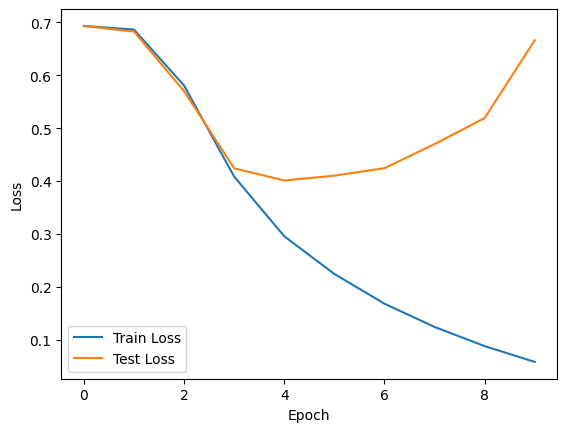

In [ ]:
mymodel = Model()
train(mymodel, train_dataloader, test_dataloader, epochs = 50, learning_rate = 0.001, early_stopping_patience = 5)

In [ ]:
#Testing the model on a new input:
input = "In the Mood for Love is a very sexy, moody, gorgeous, and stylized film. Set in Hong Kong in the early 60's, we follow the development of love between two lonely neighbors each of whom is trapped in unhappy marriages. This film captured me from the first second to the last. It's slow but visually captivating that you would continue to watch it. Everything besides of its progression was on point from cinematography to soundtrack, to lead actor performances."
tokens = tokenizer(input.lower())
token_ids = []
for token in tokens:
    if token in dictionary:
        token_id = dictionary[token]
    else:
        token_id = dictionary['<unk>']
    token_ids.append(token_id)
token_ids = token_ids[:200] + [dictionary['<pad>']] * (200 - len(token_ids))
token_ids = torch.tensor(token_ids)

mymodel.eval()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
with torch.no_grad():
  output = mymodel(token_ids)
if output > 0.5:
  print("positive review")
else:
  print("negative review")

positive review
